### AI Project: Develop simple MOE architecture

- In this project, I want to learn and apply the MOE framework into making predictions more robusts. Thus, the aim of the project is very straightforward: develop the MOE with gating network and experts. Then, evaluate it.
The steps are outlined here:
- Define the MOE architecture
- Prepare the dataset
- Train the MOE
- Evaluate the result
- Visualize the result
- Document the reports


In [1]:
# Download all of the necessary libraries

!pip install transformers
!pip install torch
!pip install datasets
!pip install matplotlib

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel
from datasets import load_dataset
import matplotlib.pyplot as plt



### Define the MOE architecture



In [3]:
# Define the expert

class Expert(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Expert, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

# Define the gating network

class GatingNetwork(nn.Module):
    def __init__(self, input_dim, num_experts):
        super(GatingNetwork, self).__init__()
        self.fc = nn.Linear(input_dim, num_experts)

    def forward(self, x):
        return torch.softmax(self.fc(x), dim=-1)


# Define the MOE
class MOEModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_experts):
        super(MOEModel, self).__init__()
        self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
        self.gate = GatingNetwork(input_dim, num_experts)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gate_outputs = self.gate(x)
        expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
        moe_output = torch.sum(gate_outputs.unsqueeze(-1) * expert_outputs, dim=1)
        return self.fc(moe_output)



### Prepare dataset



In [4]:
dataset = load_dataset('glue', 'mrpc')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_function(examples):
  return tokenizer(examples['sentence1'], examples['sentence2'], padding = 'max_length', truncation = True)

tokenized_dataset = dataset.map(tokenize_function, batched = True)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [5]:

tokenized_dataset = tokenized_dataset.remove_columns(['sentence1', 'sentence2', 'idx'])
tokenized_dataset.set_format('torch')

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['validation']

In [6]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [7]:
train_dataset

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 3668
})

In [8]:
train_dataset['input_ids']

tensor([[  101,  2572,  3217,  ...,     0,     0,     0],
        [  101,  9805,  3540,  ...,     0,     0,     0],
        [  101,  2027,  2018,  ...,     0,     0,     0],
        ...,
        [  101,  1000,  2057,  ...,     0,     0,     0],
        [  101,  1996, 26828,  ...,     0,     0,     0],
        [  101,  1996,  2382,  ...,     0,     0,     0]])

In [ ]:
len(train_dataset['input_ids'])

3668

In [ ]:
print(tokenized_dataset['train'][0]['input_ids'].shape)
# This is the input dimension to train the model

torch.Size([512])


### Train the MOE

In [44]:
def evaluate(model, eval_dataset):
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in eval_loader:
            inputs = batch['input_ids'].to(device).float()
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100}%')



In [41]:
input_dim = 512  # Input dimension should match with the dimension in the input_ids.shape
hidden_dim = 256
output_dim = 2  # Number of classes
num_experts = 3
model = MOEModel(input_dim, hidden_dim, output_dim, num_experts)

Epoch 1/10, Loss: 101.68755015704943
Epoch 2/10, Loss: 30.8935232831727
Epoch 3/10, Loss: 39.55853565050208
Epoch 4/10, Loss: 28.93291748088339
Epoch 5/10, Loss: 31.982540582573932
Epoch 6/10, Loss: 25.626076335492343
Epoch 7/10, Loss: 26.11579827847688
Epoch 8/10, Loss: 35.57124839710153
Epoch 9/10, Loss: 29.20310846933204
Epoch 10/10, Loss: 34.911656241761214


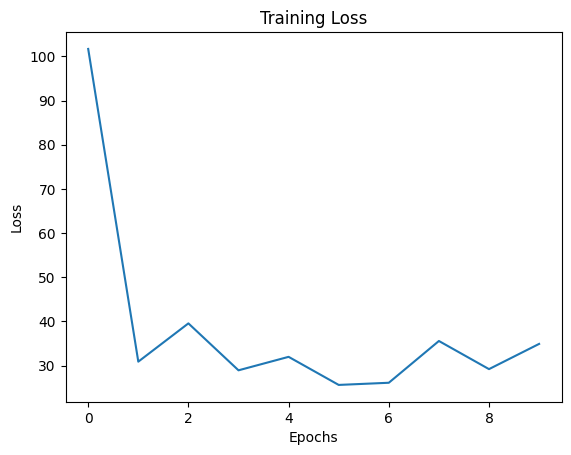

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim

# Ensure your model and data are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
def train_and_plot(model, train_dataset, epochs=10, learning_rate=1e-4):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch['input_ids'].to(device).float()
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')

    plt.plot(range(epochs), losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

train_and_plot(model, train_dataset)


In [43]:
evaluate(model, eval_dataset)

Accuracy: 57.35294117647059%


#### Testing with hidden dim 512 and num_experts 10

In [11]:
input_dim = 512  # Input dimension should match with the dimension in the input_ids.shape
hidden_dim = 512
output_dim = 2  # Number of classes
num_experts = 10
updated_model = MOEModel(input_dim, hidden_dim, output_dim, num_experts)

Epoch 1/10, Loss: 170.33135568810545
Epoch 2/10, Loss: 95.32761978688447
Epoch 3/10, Loss: 83.77726947120998
Epoch 4/10, Loss: 86.55017055843187
Epoch 5/10, Loss: 73.15031858527142
Epoch 6/10, Loss: 71.90492830276489
Epoch 7/10, Loss: 67.1633066509081
Epoch 8/10, Loss: 56.90730914447619
Epoch 9/10, Loss: 52.402572872067076
Epoch 10/10, Loss: 52.07373000849848


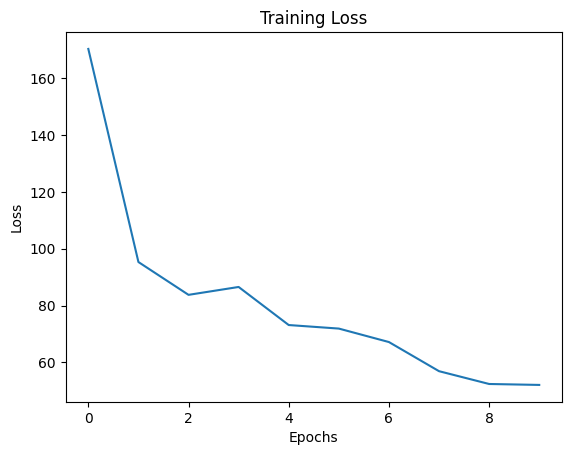

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

# Ensure your model and data are on the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
def train_and_plot(model, train_dataset, epochs=10, learning_rate=1e-4):
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    losses = []

    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            inputs = batch['input_ids'].to(device).float()
            labels = batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        avg_loss = epoch_loss / len(train_loader)
        losses.append(avg_loss)
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_loss}')

    plt.plot(range(epochs), losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

train_and_plot(updated_model, train_dataset)


### Evaluate the result

In [13]:
def evaluate(model, eval_dataset):
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in eval_loader:
            inputs = batch['input_ids'].to(device).float()
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100}%')

evaluate(model, eval_dataset)


Accuracy: 58.08823529411765%


In [39]:
evaluate(updated_model, eval_dataset)

Accuracy: 50.245098039215684%


The 4 simple experts with 256 hidden dimensions produce the accuracy of 58.09%.
The 10 simple experts with 512 hidden dimensions produce the accuracy of 50.26%.

- The conclusion is that increasing the number of experts and dimension does not neccesarily mean that the accuracy increases.

#### Testing with Drop Out

In [17]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset
# Split the dataset into training and validation sets
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    train_dataset['input_ids'], train_dataset['label'], test_size=0.1, random_state=42
)

# Create TensorDatasets
train_dataset_updated = TensorDataset(torch.tensor(train_inputs), torch.tensor(train_labels))
val_dataset_updated = TensorDataset(torch.tensor(val_inputs), torch.tensor(val_labels))


<ipython-input-17-aad0c3722d98>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset_updated = TensorDataset(torch.tensor(train_inputs), torch.tensor(train_labels))
<ipython-input-17-aad0c3722d98>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_dataset_updated = TensorDataset(torch.tensor(val_inputs), torch.tensor(val_labels))


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

def test_train_plot(train_dataset, val_dataset, num_experts = 4, learning_rate= 1e-4, epochs = 10, hidden_dim = 256):
  # Define the updated MOE Model with Dropout
  class Expert(nn.Module):
      def __init__(self, input_dim, hidden_dim):
          super(Expert, self).__init__()
          self.fc = nn.Linear(input_dim, hidden_dim)
          self.dropout = nn.Dropout(0.5)

      def forward(self, x):
          return self.dropout(self.fc(x.float()))  # Ensure input is float

  class GatingNetwork(nn.Module):
      def __init__(self, input_dim, num_experts):
          super(GatingNetwork, self).__init__()
          self.fc = nn.Linear(input_dim, num_experts)

      def forward(self, x):
          return torch.softmax(self.fc(x.float()), dim=-1)  # Ensure input is float

  class MOEModel(nn.Module):
      def __init__(self, input_dim, hidden_dim, output_dim, num_experts):
          super(MOEModel, self).__init__()
          self.experts = nn.ModuleList([Expert(input_dim, hidden_dim) for _ in range(num_experts)])
          self.gate = GatingNetwork(input_dim, num_experts)
          self.fc = nn.Linear(hidden_dim, output_dim)
          self.dropout = nn.Dropout(0.5)

      def forward(self, x):
          gate_outputs = self.gate(x)
          expert_outputs = torch.stack([expert(x) for expert in self.experts], dim=1)
          moe_output = torch.sum(gate_outputs.unsqueeze(-1) * expert_outputs, dim=1)
          return self.fc(self.dropout(moe_output))

  input_dim = 512  # Input dimension should match with the dimension in the input_ids.shape
  hidden_dim = hidden_dim
  output_dim = 2  # Number of classes
  num_experts = num_experts

  model = MOEModel(input_dim, hidden_dim, output_dim, num_experts)

  # Ensure your model and data are on the correct device
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model.to(device)

  def train_and_validate(model, train_dataset, val_dataset, epochs=epochs, learning_rate=learning_rate):
      train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
      val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

      criterion = nn.CrossEntropyLoss()
      optimizer = optim.Adam(model.parameters(), lr=learning_rate)
      scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

      train_losses = []
      val_accuracies = []

      for epoch in range(epochs):
          # Training phase
          model.train()
          epoch_loss = 0
          for batch in train_loader:
              inputs = batch[0].to(device).float()
              labels = batch[1].to(device)
              optimizer.zero_grad()
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              loss.backward()
              optimizer.step()
              epoch_loss += loss.item()
          avg_train_loss = epoch_loss / len(train_loader)
          train_losses.append(avg_train_loss)

          # Validation phase
          model.eval()
          correct = 0
          total = 0
          with torch.no_grad():
              for batch in val_loader:
                  inputs = batch[0].to(device).float()
                  labels = batch[1].to(device)
                  outputs = model(inputs)
                  _, predicted = torch.max(outputs.data, 1)
                  total += labels.size(0)
                  correct += (predicted == labels).sum().item()
          val_accuracy = correct / total
          val_accuracies.append(val_accuracy)

          # Print epoch statistics
          print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

          # Adjust the learning rate
          scheduler.step()

      # Plotting
      plt.figure(figsize=(12, 5))
      plt.subplot(1, 2, 1)
      plt.plot(range(epochs), train_losses, label='Train Loss')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title('Training Loss')
      plt.legend()

      plt.subplot(1, 2, 2)
      plt.plot(range(epochs), val_accuracies, label='Val Accuracy')
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title('Validation Accuracy')
      plt.legend()

      plt.show()

      return model

  return train_and_validate(model, train_dataset, val_dataset)


Epoch 1/10, Train Loss: 544.8127, Val Accuracy: 0.5940
Epoch 2/10, Train Loss: 430.8659, Val Accuracy: 0.5995
Epoch 3/10, Train Loss: 384.5710, Val Accuracy: 0.5777
Epoch 4/10, Train Loss: 331.2645, Val Accuracy: 0.5967
Epoch 5/10, Train Loss: 309.4232, Val Accuracy: 0.6158
Epoch 6/10, Train Loss: 310.8978, Val Accuracy: 0.6185
Epoch 7/10, Train Loss: 308.8353, Val Accuracy: 0.6213
Epoch 8/10, Train Loss: 303.5682, Val Accuracy: 0.6213
Epoch 9/10, Train Loss: 305.1166, Val Accuracy: 0.6213
Epoch 10/10, Train Loss: 312.3338, Val Accuracy: 0.6213


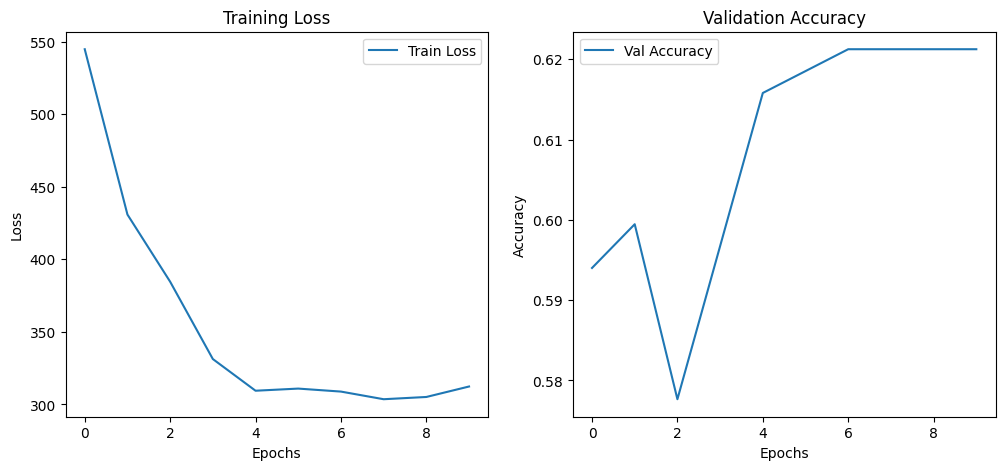

In [25]:
model_updated_4 = test_train_plot(train_dataset_updated, val_dataset_updated, 4)

Epoch 1/10, Train Loss: 563.8119, Val Accuracy: 0.5831
Epoch 2/10, Train Loss: 462.6824, Val Accuracy: 0.5640
Epoch 3/10, Train Loss: 421.0983, Val Accuracy: 0.5749
Epoch 4/10, Train Loss: 375.1406, Val Accuracy: 0.5995
Epoch 5/10, Train Loss: 357.9788, Val Accuracy: 0.5995
Epoch 6/10, Train Loss: 357.2234, Val Accuracy: 0.5886
Epoch 7/10, Train Loss: 331.0655, Val Accuracy: 0.5995
Epoch 8/10, Train Loss: 347.7057, Val Accuracy: 0.5995
Epoch 9/10, Train Loss: 338.8932, Val Accuracy: 0.5995
Epoch 10/10, Train Loss: 348.6755, Val Accuracy: 0.5995


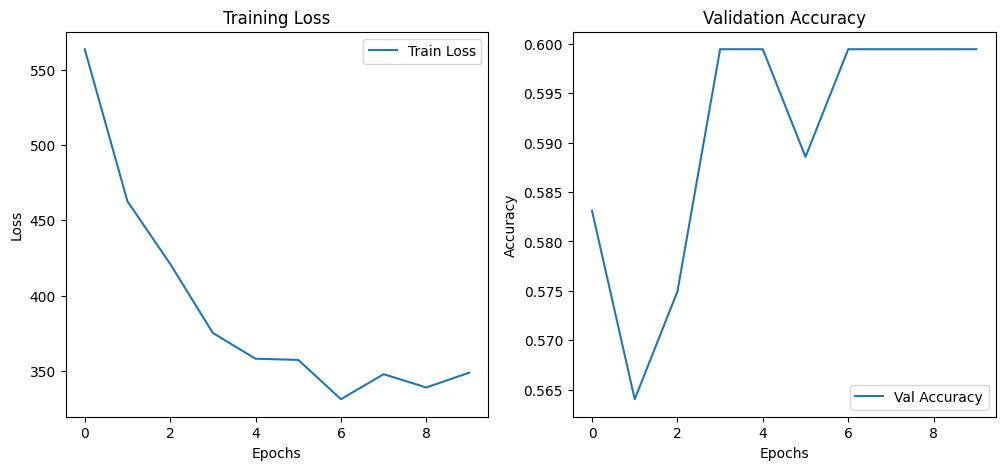

In [26]:
model_updated_6 = model_updated = test_train_plot(train_dataset_updated, val_dataset_updated, 6)


Epoch 1/6, Train Loss: 693.4685, Val Accuracy: 0.5123
Epoch 2/6, Train Loss: 673.2446, Val Accuracy: 0.5177
Epoch 3/6, Train Loss: 637.2641, Val Accuracy: 0.5341
Epoch 4/6, Train Loss: 653.3224, Val Accuracy: 0.5395
Epoch 5/6, Train Loss: 627.2403, Val Accuracy: 0.5395
Epoch 6/6, Train Loss: 642.8600, Val Accuracy: 0.5395


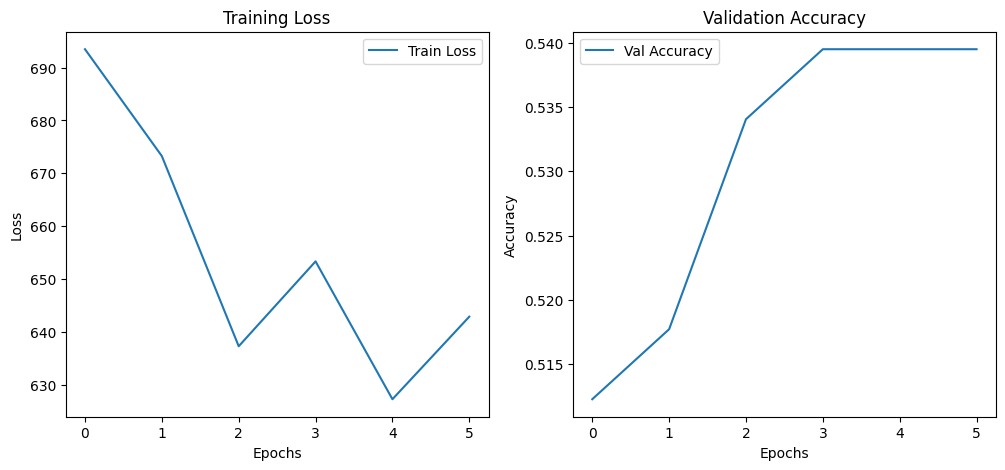

In [19]:
model_updated_4_512 = test_train_plot(train_dataset_updated, val_dataset_updated, 4, learning_rate = 1e-6, epochs = 6, hidden_dim = 512)

Epoch 1/6, Train Loss: 721.8727, Val Accuracy: 0.5095
Epoch 2/6, Train Loss: 672.0384, Val Accuracy: 0.5313
Epoch 3/6, Train Loss: 654.5832, Val Accuracy: 0.5450
Epoch 4/6, Train Loss: 673.0458, Val Accuracy: 0.5504
Epoch 5/6, Train Loss: 622.9160, Val Accuracy: 0.5559
Epoch 6/6, Train Loss: 638.2551, Val Accuracy: 0.5586


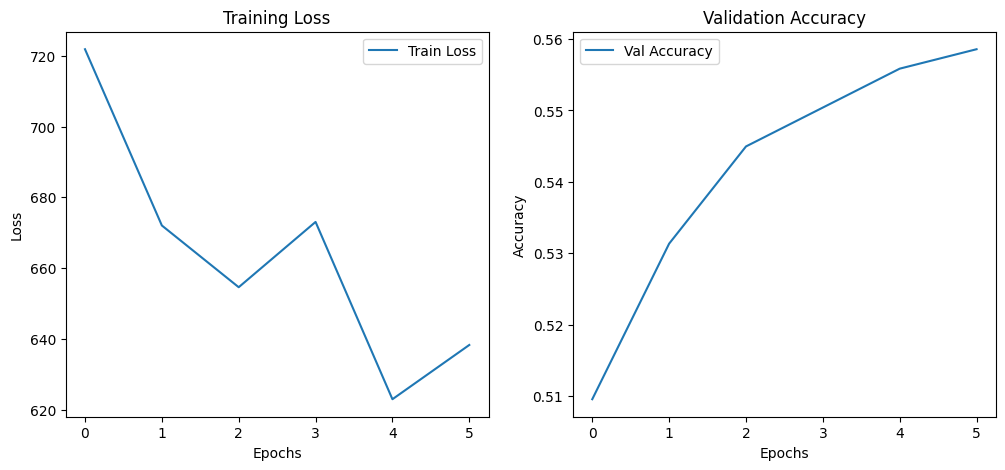

In [20]:
model_updated_6_512 = test_train_plot(train_dataset_updated, val_dataset_updated, 6, learning_rate = 1e-6, epochs = 6, hidden_dim = 512)

In [27]:
evaluate(model_updated_4, eval_dataset)

Accuracy: 66.66666666666666%


In [30]:
evaluate(model_updated_6, eval_dataset)

Accuracy: 65.93137254901961%


In [24]:
evaluate(model_updated_4_512, eval_dataset)

Accuracy: 54.166666666666664%


In [28]:
evaluate(model_updated_6_512, eval_dataset)

Accuracy: 53.18627450980392%


Drop-out helps to increase the accuracy to 66.6%.
Exploring with the number of experts and dimensions, it seems like 4 experts and 256 hidden dimension prodce comparatively good result, although more exploration is needed to determine the best number of experts and dimensions.

### Change the MOE architecture
  - Add RNN, CNN layers
  - The number of experts
  - Hidden Dimension

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import itertools

def test_train_plot(train_dataset, val_dataset, num_experts=4, learning_rate=1e-4, epochs=10, hidden_dim=256):

    class SimpleExpert(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(SimpleExpert, self).__init__()
            self.fc = nn.Linear(input_dim, hidden_dim)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            return self.dropout(torch.relu(self.fc(x.float())))

    class TwoLayerExpert(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(TwoLayerExpert, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            x = torch.relu(self.fc1(x.float()))
            x = self.dropout(x)
            return torch.relu(self.fc2(x))

    class ThreeLayerExpert(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(ThreeLayerExpert, self).__init__()
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            self.fc2 = nn.Linear(hidden_dim, hidden_dim)
            self.fc3 = nn.Linear(hidden_dim, hidden_dim)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            x = torch.relu(self.fc1(x.float()))
            x = self.dropout(x)
            x = torch.relu(self.fc2(x))
            x = self.dropout(x)
            return torch.relu(self.fc3(x))

    class CNNExpert(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(CNNExpert, self).__init__()
            self.conv1 = nn.Conv1d(in_channels=1, out_channels=hidden_dim, kernel_size=3, padding=1)
            self.conv2 = nn.Conv1d(in_channels=hidden_dim, out_channels=hidden_dim, kernel_size=3, padding=1)
            self.fc = nn.Linear(hidden_dim * input_dim, hidden_dim)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add channel dimension for convolution
            x = torch.relu(self.conv1(x))
            x = torch.relu(self.conv2(x))
            x = x.view(x.size(0), -1)  # Flatten
            x = self.dropout(x)
            return self.fc(x)

    class RNNExpert(nn.Module):
        def __init__(self, input_dim, hidden_dim):
            super(RNNExpert, self).__init__()
            self.rnn = nn.RNN(input_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, hidden_dim)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            x = x.unsqueeze(1)  # Add sequence dimension
            x, _ = self.rnn(x.float())
            x = self.dropout(x[:, -1, :])  # Use the output from the last time step
            return torch.relu(self.fc(x))

    class GatingNetwork(nn.Module):
        def __init__(self, input_dim, num_experts):
            super(GatingNetwork, self).__init__()
            self.fc1 = nn.Linear(input_dim, input_dim)
            self.fc2 = nn.Linear(input_dim, num_experts)

        def forward(self, x):
            x = torch.relu(self.fc1(x.float()))
            return torch.softmax(self.fc2(x), dim=-1)

    class MOEModel(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, num_experts):
            super(MOEModel, self).__init__()
            self.experts = nn.ModuleList([
                SimpleExpert(input_dim, hidden_dim),
                TwoLayerExpert(input_dim, hidden_dim),
                ThreeLayerExpert(input_dim, hidden_dim),
                CNNExpert(input_dim, hidden_dim),
                RNNExpert(input_dim, hidden_dim),
                RNNExpert(input_dim, hidden_dim)
            ])
            self.gate = GatingNetwork(input_dim, num_experts)
            self.fc = nn.Linear(hidden_dim, output_dim)
            self.dropout = nn.Dropout(0.5)

        def forward(self, x):
            gate_outputs = self.gate(x)
            expert_outputs = torch.stack([expert(x) for expert in self.experts[:num_experts]], dim=1)
            moe_output = torch.sum(gate_outputs.unsqueeze(-1) * expert_outputs, dim=1)
            return self.fc(self.dropout(moe_output))

    input_dim = 512
    output_dim = 2

    model = MOEModel(input_dim, hidden_dim, output_dim, num_experts)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    def train_and_validate(model, train_dataset, val_dataset, epochs, learning_rate):
        train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

        train_losses = []
        val_accuracies = []

        for epoch in range(epochs):
            model.train()
            epoch_loss = 0
            for batch in train_loader:
                inputs = batch[0].to(device).float()
                labels = batch[1].to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_train_loss = epoch_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in val_loader:
                    inputs = batch[0].to(device).float()
                    labels = batch[1].to(device)
                    outputs = model(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_accuracy = correct / total
            val_accuracies.append(val_accuracy)

            print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

            scheduler.step()

        return model

    return train_and_validate(model, train_dataset, val_dataset, epochs, learning_rate)

def hyperparameter_tuning(train_dataset, val_dataset):
    num_experts_options = [3, 4, 5, 6, 7]
    epochs_options = [10, 20, 30]
    learning_rate_options = [1e-4, 1e-3, 1e-2]
    hidden_dim_options = [128, 256, 512]

    best_accuracy = 0
    best_params = {}

    for num_experts, epochs, learning_rate, hidden_dim in itertools.product(
            num_experts_options, epochs_options, learning_rate_options, hidden_dim_options):
        print(f"Testing with num_experts={num_experts}, epochs={epochs}, learning_rate={learning_rate}, hidden_dim={hidden_dim}")
        model = test_train_plot(train_dataset, val_dataset, num_experts, learning_rate, epochs, hidden_dim)
        _, val_accuracies = model
        if max(val_accuracies) > best_accuracy:
            best_accuracy = max(val_accuracies)
            best_params = {
                'num_experts': num_experts,
                'epochs': epochs,
                'learning_rate': learning_rate,
                'hidden_dim': hidden_dim
            }

    print(f"Best parameters: {best_params} with accuracy: {best_accuracy}")



In [32]:
def evaluate(model, eval_dataset):
    eval_loader = torch.utils.data.DataLoader(eval_dataset, batch_size=16)
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in eval_loader:
            inputs = batch['input_ids'].to(device).float()
            labels = batch['label'].to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100}%')



Epoch 1/10, Train Loss: 438.0162, Val Accuracy: 0.6267
Epoch 2/10, Train Loss: 125.6730, Val Accuracy: 0.5858
Epoch 3/10, Train Loss: 56.3245, Val Accuracy: 0.5123
Epoch 4/10, Train Loss: 48.8656, Val Accuracy: 0.5668
Epoch 5/10, Train Loss: 52.9283, Val Accuracy: 0.5586
Epoch 6/10, Train Loss: 49.5328, Val Accuracy: 0.6049
Epoch 7/10, Train Loss: 53.1592, Val Accuracy: 0.5967
Epoch 8/10, Train Loss: 49.1848, Val Accuracy: 0.6240
Epoch 9/10, Train Loss: 29.6917, Val Accuracy: 0.5886
Epoch 10/10, Train Loss: 11.6456, Val Accuracy: 0.6022


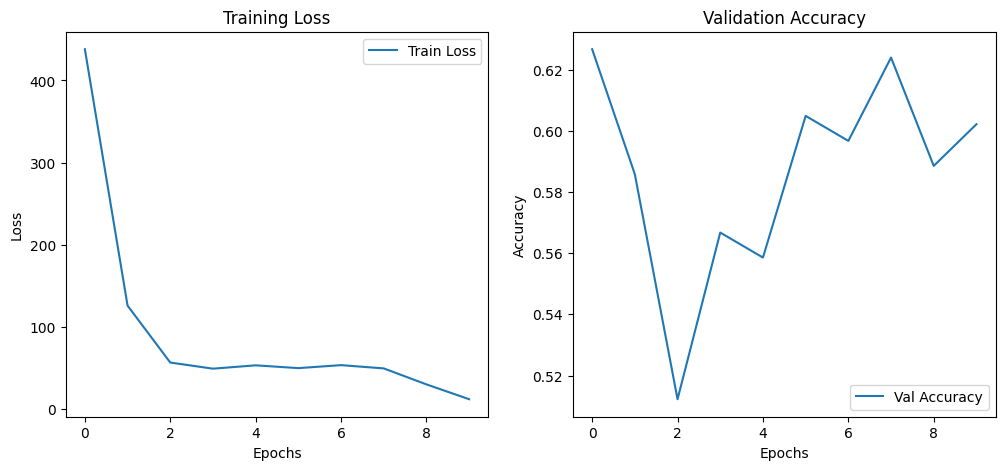

In [36]:
model_updated_3_cnn_rnn = test_train_plot(train_dataset_updated, val_dataset_updated, num_experts=3, learning_rate=1e-3, epochs=10, hidden_dim=256)

In [37]:
evaluate(model_updated_3_cnn_rnn, eval_dataset)

Accuracy: 66.42156862745098%


Epoch 1/10, Train Loss: 474.2750, Val Accuracy: 0.6022
Epoch 2/10, Train Loss: 140.9013, Val Accuracy: 0.5395
Epoch 3/10, Train Loss: 63.0325, Val Accuracy: 0.5531
Epoch 4/10, Train Loss: 50.5606, Val Accuracy: 0.6104
Epoch 5/10, Train Loss: 47.6892, Val Accuracy: 0.5722
Epoch 6/10, Train Loss: 55.7002, Val Accuracy: 0.5232
Epoch 7/10, Train Loss: 60.0857, Val Accuracy: 0.5749
Epoch 8/10, Train Loss: 59.3420, Val Accuracy: 0.6158
Epoch 9/10, Train Loss: 60.6992, Val Accuracy: 0.6485
Epoch 10/10, Train Loss: 39.5557, Val Accuracy: 0.6431


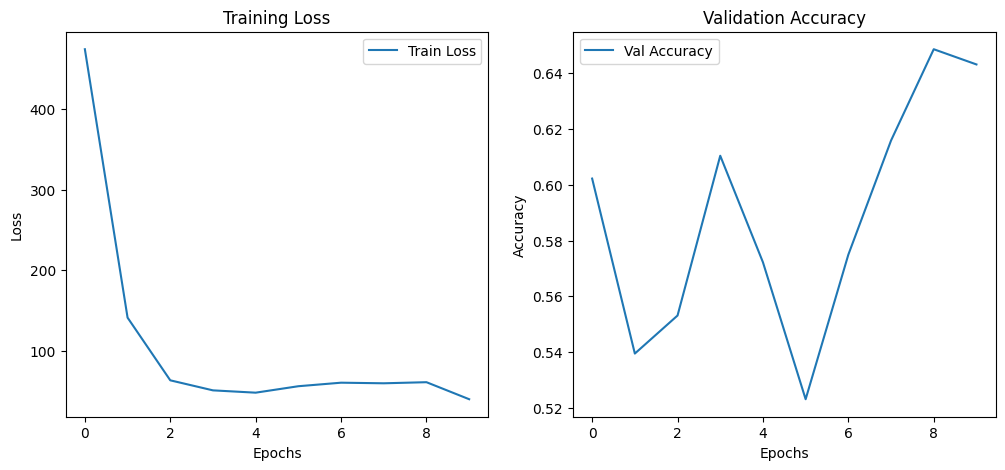

Accuracy: 65.68627450980392%


In [34]:
model_updated_6_cnn_rnn = test_train_plot(train_dataset_updated, val_dataset_updated, num_experts=6, learning_rate=1e-3, epochs=10, hidden_dim=256)
evaluate(model_updated_6_cnn_rnn, eval_dataset)

Epoch 1/10, Train Loss: 457.1588, Val Accuracy: 0.4469
Epoch 2/10, Train Loss: 141.3008, Val Accuracy: 0.5913
Epoch 3/10, Train Loss: 60.3202, Val Accuracy: 0.5477
Epoch 4/10, Train Loss: 63.5236, Val Accuracy: 0.6322
Epoch 5/10, Train Loss: 64.8026, Val Accuracy: 0.6267
Epoch 6/10, Train Loss: 63.9099, Val Accuracy: 0.6458
Epoch 7/10, Train Loss: 62.0288, Val Accuracy: 0.4496
Epoch 8/10, Train Loss: 37.0157, Val Accuracy: 0.6403
Epoch 9/10, Train Loss: 12.8771, Val Accuracy: 0.5995
Epoch 10/10, Train Loss: 6.1740, Val Accuracy: 0.5668


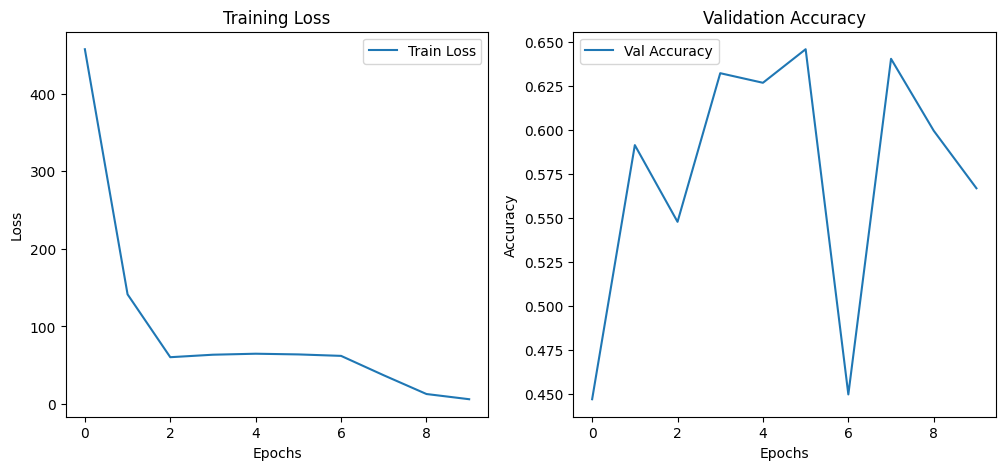

Accuracy: 65.44117647058823%


In [40]:
model_updated_cnn_rnn_5 = test_train_plot(train_dataset_updated, val_dataset_updated, num_experts=5, learning_rate=1e-3, epochs=10, hidden_dim=256)
evaluate(model_updated_cnn_rnn_5, eval_dataset)

### Document the reports
In this project, we implemented and evaluated a simple Mixture of Experts (MOE) model to improve task distribution and accuracy in multi-task learning scenarios. Our findings indicate that a model with 4 simple experts and 256 hidden dimensions achieved an accuracy of 58.09%, while increasing the number of experts and dimensions to 10 and 512, respectively, resulted in a lower accuracy of 50.26%. This suggests that adding more experts and dimensions does not necessarily enhance performance. Additionally, incorporating dropout improved the model's accuracy to 66.6%. Advanced architectures using RNN and CNN experts did not significantly increase accuracy, with the best result of 66.42% achieved using 4-6 experts with advanced layers. These results highlight the importance of optimizing expert numbers and dimensions, as well as the potential benefits of dropout implementation.






